In [152]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.saving import save_model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [153]:
df = pd.read_csv('model_data_1min.csv')
df.head()

,Unnamed: 0,trade_id,product_id,price,size,time,side,bid,ask,exchange,...,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,60305,590641283,ETH-USD,3598.16,0.013755,2025-01-04 06:38:20.767435+00:00,SELL,NaN,NaN,NaN,...,36308.0,36308.0,36308.0,36308.0,36308.0,36308.0,227275.0,227275.0,143784.0,60293.0
1,60304,590641310,ETH-USD,3598.95,0.002479,2025-01-04 06:38:35.543964+00:00,SELL,NaN,NaN,NaN,...,36309.0,36309.0,36309.0,36309.0,36309.0,36309.0,227274.0,227274.0,143783.0,60292.0
2,60303,590641344,ETH-USD,3598.15,3.565571,2025-01-04 06:38:55.779501+00:00,BUY,NaN,NaN,NaN,...,36310.0,36310.0,36310.0,36310.0,36310.0,36310.0,227273.0,227273.0,143782.0,60291.0
3,60302,590641361,ETH-USD,3597.71,0.000987,2025-01-04 06:39:14.353069+00:00,BUY,NaN,NaN,NaN,...,36311.0,36311.0,36311.0,36311.0,36311.0,36311.0,227272.0,227272.0,143781.0,60290.0
4,60301,590641382,ETH-USD,3597.72,0.200000,2025-01-04 06:39:29.902680+00:00,SELL,NaN,NaN,NaN,...,36312.0,36312.0,36312.0,36312.0,36312.0,36312.0,227271.0,227271.0,143780.0,60289.0


In [154]:
#data set is one datapoint every 15 seconds. Want to look once every 3 minutes instead. So we're going to limit our dataset as such
# Make sure 'time' is a datetime object
df['time'] = pd.to_datetime(df['time'])

# Set it as index
df.set_index('time', inplace=True)

# Resample every 6 minutes
minute = 12
df_resampled = df.resample(f'{minute}T').agg({
    'price': 'last',  # Last traded price in the interval
    'size': 'sum',    # Total volume traded in the interval
    'side': lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN'  # Most common side or fallback
})

#x = 4000 #start data a 3/1

# Grab everything after (and including) the 83,000th row
#df_resampled = df_resampled.iloc[x:]

df_resampled = df_resampled.reset_index()
df_resampled.head()
df_resampled.to_csv('resampled_data.csv')

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_14957/991056651.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(f'{minute}T').agg({


In [155]:
df_resampled.head()

,time,price,size,side
0,2025-01-04 06:36:00+00:00,3594.34,6.551917,SELL
1,2025-01-04 06:48:00+00:00,3598.94,2.166045,SELL
2,2025-01-04 07:00:00+00:00,3604.52,6.454355,SELL
3,2025-01-04 07:12:00+00:00,3599.73,15.299945,SELL
4,2025-01-04 07:24:00+00:00,3601.35,9.520276,SELL


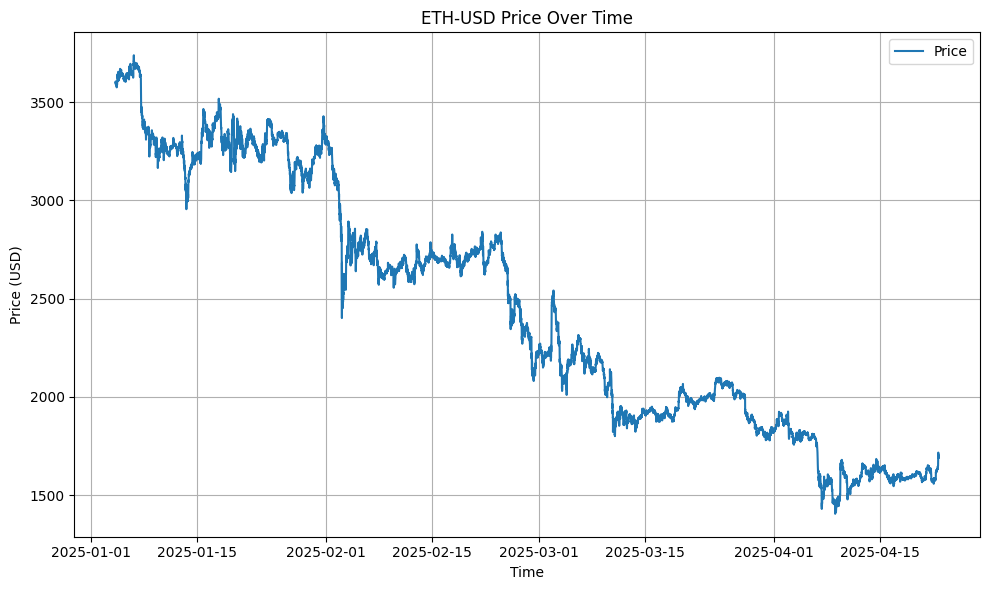

In [156]:
df_trades = df_resampled

# Convert 'price' column to numeric
df_trades['price'] = pd.to_numeric(df_trades['price'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_trades['time'], df_trades['price'], linestyle='-', label='Price')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('ETH-USD Price Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [157]:
# Ensure time column is sorted
df_trades = df_trades.sort_values('time')

# Scale the 'price' and 'size' column
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])

# Create sequences of data for LSTM
sequence_length = 10  # Sequence of 10 observations
forecast_steps = 5     # Predict 5 steps into the future

In [158]:
# Compute percent   difference
df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage

# Drop the first row since pct_change for first row is NaN
df_trades = df_trades.dropna(subset=['pct_change']).reset_index(drop=True)

df_trades = df_trades.drop(columns=[col for col in df_trades.columns if col.startswith("Unnamed")])

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_14957/1791461416.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage


In [159]:
df_trades['sma_5'] = df_trades['price_scaled'].rolling(window=5).mean()
df_trades['momentum'] = df_trades['price_scaled'] - df_trades['price_scaled'].shift(5)
df_trades.dropna(subset=['sma_5', 'momentum'], inplace=True)
df_trades.head()

,time,price,size,side,price_scaled,pct_change,sma_5,momentum
5,2025-01-04 07:48:00+00:00,3592.58,9.574716,SELL,0.937762,-0.175609,0.940693,-0.002727
6,2025-01-04 08:00:00+00:00,3600.20,4.764039,SELL,0.941029,0.212104,0.940323,-0.001853
7,2025-01-04 08:12:00+00:00,3595.58,4.483896,SELL,0.939048,-0.128326,0.939967,-0.001780
8,2025-01-04 08:24:00+00:00,3597.75,7.692453,SELL,0.939979,0.060352,0.939658,-0.001544
9,2025-01-04 08:36:00+00:00,3585.29,19.931080,SELL,0.934635,-0.346328,0.938491,-0.005837


In [160]:
# split data into sequences and X and y
X = []
y = []

prices = df_trades['price_scaled'].values

for i in range(len(prices) - sequence_length - forecast_steps):
    #build feature set
    X.append(prices[i:i + sequence_length])

    future_price = prices[i + sequence_length + forecast_steps - 1]
    current_price = prices[i+sequence_length]
    pct_change = (future_price - current_price) / current_price
    if pct_change < -0.01:
        label = 0  # SELL
    elif pct_change > 0.01:
        label = 2  # BUY
    else:
        label = 1  # HOLD

    y.append(label)

X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=3)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_14957/1470303303.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  pct_change = (future_price - current_price) / current_price


In [161]:
y_classes = np.argmax(y, axis=1)
unique, counts = np.unique(y_classes, return_counts=True)
class_counts = dict(zip(unique, counts))
print(class_counts)

{0: 3133, 1: 6807, 2: 3045}


In [162]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [163]:
X_train.shape

(10388, 10, 1)

In [164]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,595 (807.01 KB)

 Trainable params: 206,595 (807.01 KB)

 Non-trainable params: 0 (0.00 B)

In [165]:
# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5882 - loss: 0.9542 - val_accuracy: 0.2514 - val_loss: 1.1120
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5951 - loss: 0.9321 - val_accuracy: 0.2514 - val_loss: 1.1175
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5984 - loss: 0.9274 - val_accuracy: 0.2514 - val_loss: 1.1111
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5953 - loss: 0.9306 - val_accuracy: 0.2514 - val_loss: 1.1135
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5847 - loss: 0.9408 - val_accuracy: 0.2514 - val_loss: 1.1458
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5928 - loss: 0.9309 - val_accuracy: 0.2514 - val_loss: 1.1399
Epoch 7/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5914 - loss: 0.9331 - val_accuracy: 0.2514 - val_loss: 1.1476
Epoch 8/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5983 - loss: 0.9262 - 

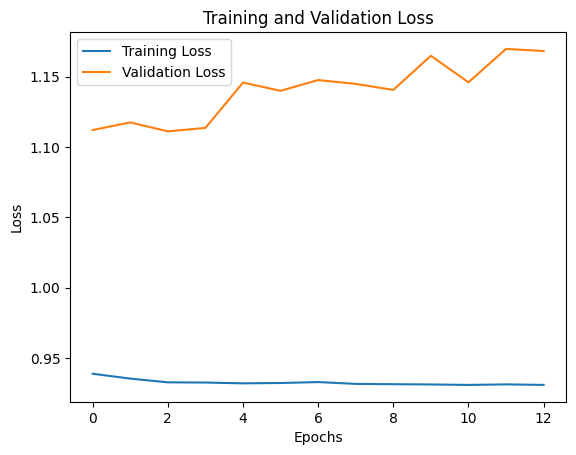

In [166]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [167]:
#save model to h5 format because mac M1 is silly
#model.save("models/model.h5", save_format='h5')
#save model to convert to ONNX model later
save_model(model=model, filepath="models/model.keras")

In [168]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and test labels to get original prices
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [169]:
model.get_metrics_result()

{'accuracy': 0.2514439821243286, 'loss': 1.1681900024414062}

In [170]:
predictions_scaled[1]

array([0.2865182 , 0.40078524, 0.31269664], dtype=float32)

In [171]:
y_test[10]

array([0., 0., 1.])

In [172]:
print(f"--------Model Information--------\r\nInterval: {minute * 60} seconds\r\nsequence_length: {sequence_length}\r\nforecast_steps: {forecast_steps}")

--------Model Information--------
Interval: 720 seconds
sequence_length: 10
forecast_steps: 5
